In [2]:
import pandas as pd
import recordlinkage as rl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow
import dask.dataframe as dd
# get CPU count
import multiprocessing
CPU_COUNT = multiprocessing.cpu_count()

def attach_ori_feature(to_attach, to_attach_recid_left, to_attach_recid_right, left_df, right_df, suffixes):
    to_attach = to_attach.merge(left_df, left_on = to_attach_recid_left, right_on = 'recid', how = 'left')
    to_attach = to_attach.merge(right_df, left_on = to_attach_recid_right, right_on = 'recid', how = 'left', suffixes = suffixes)
    return to_attach

def plot_feature_importance(fields, feature_importances):
    df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()
import psutil
# Function to report RAM usage
def report_ram_usage():
    process = psutil.Process()
    ram_usage = process.memory_info().rss / (1024 ** 2)  # in MB
    # print(f"Current RAM usage: {ram_usage:.2f} MB")
    # human readable GiB
    print(f"Current RAM usage: {ram_usage / 1024:.2f} GiB")

# Report RAM before starting
report_ram_usage()

/users/xiet13/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Current RAM usage: 0.33 GiB


## read and merge

In [28]:
# read matches
# df = pd.read_csv("../int_data/all_patents_pred_conflict_resolved_bool_threshold_0_9999.csv")
# df = pd.read_csv('../int_data/US_phonetic_name_strict.csv') # newer
df = pd.read_csv('../int_data/US_phonetic_name_strict_43958.csv')
# how many rows have no industry info?
df.occhisco.isna().sum(), df.occhisco.value_counts()

(989,
 occhisco
 61110.0    4742
 21130.0    3955
 41010.0    3189
 83400.0    2992
 99999.0    2004
            ... 
 94920.0       1
 6170.0        1
 2490.0        1
 54060.0       1
 7110.0        1
 Name: count, Length: 504, dtype: int64)

In [29]:
# TODO: create patent cleaned by Flippo's R code
# read original patent (untruncated)
patent = pd.read_pickle(f'../int_data/sub_patents_4omini_ver0_2_extrac_first_600_chars_309035_docs.pkl')
patent = patent.drop(columns = ['description'])
patent = patent[(patent.foreign != True)].reset_index(drop = True)

# 'Marshall_2/ori_data/US_patent/PatentsDataUS_Clean.csv'
ori_desc = pd.read_feather('../int_data/PatentsDataUS_Clean.feather')
# subset US
patent = pd.merge(left = patent, right = ori_desc[['publicationnumber', 'Description']], on = ['publicationnumber']).reset_index(drop = True)
patent = patent.rename(columns = {'Description':'description'})
# # make street upper 
# patent.street = patent.street.apply(lambda x:x.upper() if x else x)

# # make capital
# patent['name'] =patent.name.apply(lambda x:x.upper() if x else x)
# patent['pname']=patent.name.apply(lambda x:' '.join(x.split(' ')[:-1]) if x else x)
# patent['sname'] =patent.name.apply(lambda x:x.split(' ')[-1] if x else x)

# assign index
patent = patent.drop_duplicates(subset= ['publicationnumber', 'inventor_no'])
assert patent.set_index(['publicationnumber', 'inventor_no']).index.is_unique
patent

,publicationnumber,X,Publication.date,Title,year,parsed_desc,prompt_tokens,completion_tokens,total_tokens,cost,...,county,state,region,foreign,full_address,fsull_address,pname,sname,inventor_no,description
0,US343063A,47890,01/06/1886,None,1886,"{""inventors"":[{""name"":""Charles F. Plumb"",""sex""...",1037,67,1104,0.000196,...,Oakland,Michigan,None,False,"Waterford, Oakland, Michigan","Waterford, Oakland, Michigan",CHARLES F.,PLUMB,0,"Application filed November 24, 1885. Serial No..."
1,US343064A,47891,01/06/1886,None,1886,"{""inventors"":[{""name"":""William F. Price"",""sex""...",1035,73,1108,0.000199,...,Chester,Pennsylvania,None,False,"West Caln township, Chester County, Pennsylvania","West Caln township, Chester County, Pennsylvania",WILLIAM F.,PRICE,0,"Application filed April 1,1886. Serial No. 197..."
2,US343065A,47892,01/06/1886,None,1886,"{""inventors"":[{""name"":""Thomas B. Purves"",""sex""...",1033,78,1111,0.000202,...,Rensselaer,New York,None,False,"Greenbush, Rensselaer, New York","Greenbush, Rensselaer, New York",THOMAS B.,PURVES,0,"Application filed April 16, 1886. Serial No. 1..."
3,US343066A,47893,01/06/1886,None,1886,"{""inventors"":[{""name"":""William D. Ready"",""sex""...",1022,65,1087,0.000192,...,Kings,New York,None,False,"South Brooklyn, Kings, New York","South Brooklyn, Kings, New York",WILLIAM D.,READY,0,"Application filed February 23, 1886. Serial No..."
4,US343067A,47894,01/06/1886,None,1886,"{""inventors"":[{""name"":""John F. Boeking"",""sex"":...",1036,61,1097,0.000192,...,Jackson,Michigan,None,False,"Jackson, Jackson, Michigan","Jackson, Jackson, Michigan",JOHN F.,BOEKING,0,"Application filed September 4, 1885. Serial No..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348729,US215191A,50407,06/05/1879,None,1879,"{""inventors"":[{""name"":""N. PETERS"",""sex"":0,""occ...",1096,187,1283,0.000277,...,None,District of Columbia,None,False,"Washington, D C","Washington, D C",N.,PETERS,0,"N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C..."
348730,US215191A,50407,06/05/1879,None,1879,"{""inventors"":[{""name"":""N. PETERS"",""sex"":0,""occ...",1096,187,1283,0.000277,...,None,Rhode Island,None,False,"East Providence, Rhode Island","East Providence, Rhode Island",GEORGE F.,WILSON,1,"N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C..."
348731,US215191A,50407,06/05/1879,None,1879,"{""inventors"":[{""name"":""N. PETERS"",""sex"":0,""occ...",1096,187,1283,0.000277,...,None,Rhode Island,None,False,"Providence, Rhode Island","Providence, Rhode Island",CHARLES A.,CATLIN,2,"N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C..."
348732,US215192A,50408,06/05/1879,None,1879,"{""inventors"":[{""name"":""George F. Wilson"",""sex""...",1085,121,1206,0.000235,...,Providence,Rhode Island,None,False,"East Providence, Rhode Island","East Providence, Rhode Island",GEORGE F.,WILSON,0,Sheets—Sheet 1. G. F. WILSON. Apparatus for Dr...


In [30]:
ori_desc.Title.value_counts() # Only 189 rows got title in the description (or not in it?) -> We don't need to filter Title out from description

Title
ELECTRO—MAGNETIC MOTOR                                        6
ELECTRO-MAGNETIC MOTOR                                        4
CLEVIS                                                        4
FENCE-POST                                                    3
TRANSFORMER OR CONVERTER FOR ALTERNATING ELECTRIC CURRENTS    2
                                                             ..
PLOW                                                          1
IMPROVEMENTS IN CLOTHES-DRIERS                                1
IMPROVEMENT IN BLAST-FURNACES                                 1
SEPARATOR TO BE USED IN DISTELLING LIQUES                     1
ELECTRICAL TRANSFORMER OR INDUCTION DEVICE                    1
Name: count, Length: 189, dtype: int64

In [31]:
ori_desc.shape[0], patent.foreign.value_counts()

(309035,
 foreign
 False    306285
 Name: count, dtype: int64)

In [32]:
df = pd.merge(left = df, right = patent[['publicationnumber', 'inventor_no', 'description', 'address', 'street', 'city', 'county',
       'state', 'region', 'full_address']], left_on = [ 'patent_id', 'patent_count'], right_on = ['publicationnumber', 'inventor_no'])


In [33]:
df

,recid,patent_id,patent_count,Publication.date,year,sexpatent,llm_inferred_occupation,llm_inferred_industry,age,sexcensus,...,publicationnumber_y,inventor_no_y,description,address,street,city,county,state,region,full_address
0,28434939.0,US99984A,1.0,15/02/1870,1870.0,1.0,Mechanical engineers,Manufacturing and related services,29.0,1.0,...,US99984A,1,N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON D. C...,"{'street': '', 'city': 'Buffalo', 'county': 'E...",None,Buffalo,Erie,New York,None,"Buffalo, NY"
1,42694357.0,US99931A,1.0,15/02/1870,1870.0,1.0,Agricultural engineer,Agriculture,62.0,1.0,...,US99931A,1,"N.PETERS, PHOTO-LITHOGRAPHER, WASHINGTON. D. C...","{'street': '', 'city': 'Clio', 'county': 'Marl...",None,Clio,Marlborough,South Carolina,South Atlantic Division,"Clio, South Carolina"
2,19652488.0,US113301A,1.0,04/04/1871,1871.0,1.0,Engineering technicians nec,Manufacturing of tools and machinery,53.0,1.0,...,US113301A,1,Afar. Jo. //03a/ A/a/z/J J//. /. /3// N. PETER...,"{'street': '', 'city': 'Westborough', 'county'...",None,Westborough,Worcester,Massachusetts,None,"Westborough, Worcester, Massachusetts"
3,28763593.0,US115611A,0.0,06/06/1871,1871.0,1.0,Engineering technicians nec,Transportation equipment manufacturing,57.0,1.0,...,US115611A,0,D. HITCHINGS. Improvement in.Modes of Expandin...,"{'street': '', 'city': 'Litchfield', 'county':...",None,Litchfield,Herkimer,New York,None,"Litchfield, Herkimer, New York"
4,8773701.0,US116289A,0.0,27/06/1871,1871.0,1.0,Engineering technicians nec,Manufacturing,35.0,1.0,...,US116289A,0,TfjJDFinK. ^oiatlpAtandardin^afon Patented Jun...,"{'street': '', 'city': 'Windsor', 'county': 'S...",None,Windsor,Shelby,Illinois,None,"Windsor, Shelby, Illinois"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43953,52235301.0,US114647A,0.0,09/05/1871,1871.0,1.0,Engineers,Manufacturing,17.0,1.0,...,US114647A,0,"No. 114,647. G. A. COOPER &amp; C. SOUTHWORTH....",None,None,None,None,None,None,None
43954,51359288.0,US386582A,0.0,24/07/1888,1888.0,1.0,Engineers (HISCO 214),Rail Transportation,37.0,1.0,...,US386582A,0,"Application filed Aprils, 1888. Serial No. 269...",None,None,None,None,None,None,None
43955,55325116.0,US183513A,2.0,24/10/1876,1876.0,NaN,NaN,NaN,24.0,1.0,...,US183513A,2,"No. 183,513. Sheets—Sheet 1. A. RICHMOND. RANG...","{'street': '', 'city': 'BROOKLYN', 'county': '...",None,BROOKLYN,CONNECTICUT,None,None,
43956,50584598.0,US102013A,1.0,19/04/1870,1870.0,1.0,Inventors,Manufacturing,29.0,2.0,...,US102013A,1,"79/04,0/3. .Fafezztea?Eftrz? /ft, /8χ&lt;?. N....",None,None,None,None,None,None,None


In [34]:
df.patent_id.nunique()

42946

## Aggregate inventor industries for each patent


In [35]:
def custom_agg(x):
    return list(x.dropna())

df_per_patent = df.groupby('patent_id').agg({
    'recid':list,
    'occhisco': list,
    'description': 'first',
    'street': custom_agg,
    'city': custom_agg,
    'county': custom_agg,
    'state': custom_agg,
    'region': custom_agg,
    'full_address': custom_agg
}).reset_index()


In [36]:
df_per_patent

,patent_id,recid,occhisco,description,street,city,county,state,region,full_address
0,US100001A,[1119227.0],[54010.0],J. ARRINGTON. Walking Planter. N. PETERS. PHOT...,[],[Livingston],[Sumter],[Alabama],[],"[Livingston, Sumter, Alabama]"
1,US100007A,[38084797.0],[83850.0],Ι/ί/ΐΒ/9^21 N.PETERS. PHOTO-UTHOGRAPHER. WASHI...,[],[Altoona],[Blair],[Pennsylvania],[],"[Altoona, Blair, Pennsylvania]"
2,US100024A,[40470809.0],[87340.0],"No. 100,024. G. PROS. STOVE GRATE. Patented Fe...",[],[Philadelphia],[],[Pennsylvania],[],"[Philadelphia, Pennsylvania]"
3,US100037A,[6771858.0],[83400.0],"No. 100,037. A. D. HOFFMAN. Till Alarm. Patent...",[],[Chicago],[Cook],[Illinois],[],"[Chicago, Cook, Illinois]"
4,US100041A,[14941022.0],[99999.0],"N.PETERS, PHOTO-LITHOGRAPHER, WASHINGTON. DC. ...",[],[Maysville],[Mason],[Kentucky],[East South Central Division],"[Maysville, Kentucky]"
...,...,...,...,...,...,...,...,...,...,...
42941,US99984A,[28434939.0],[39310.0],N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON D. C...,[],[Buffalo],[Erie],[New York],[],"[Buffalo, NY]"
42942,US99985A,[31600299.0],[75600.0],"WEGNER &amp;, SCHLEETER. Churn. Patented Feb. ...",[],[West Troy],[Albany],[New York],[],"[West Troy, Albany, New York]"
42943,US99987A,[29132340.0],[79920.0],ft. JY&amp;. 8808/. 437 Τίύ./5./8/0. N. PETERS...,[],[Brooklyn],[Kings],[New York],[],"[Brooklyn, Kings County, New York]"
42944,US99991A,[46549109.0],[81300.0],"F-F/ibml·, Ctimieiw. Mb. ffffffff/. EhhiU J/ /...",[],[Londonderry],[Windham],[Vermont],[],"[Londonderry, Windham, Vermont]"


## Clean patents


In [37]:
# Authors_US.csv and Authors_wide_US.csv
# Authors_wide_US_csv = name_info[['publicationnumber', 'name']].groupby('publicationnumber').agg(
#     {'name': lambda x: ', '.join([str(i) for i in x if pd.notna(i)]) if not x.empty else None}
# ).reset_index()
# Authors_wide_US_csv.name.map(len).hist()
# Authors_US_csv = name_info[['publicationnumber', 'inventor_no', 'name']]

# Authors_US_csv.to_csv('../int_data/Authors_US.csv', index = False)
# Authors_wide_US_csv.to_csv('../int_data/Authors_wide_US.csv', index = False)

In [38]:
# # authors, occupation strings and titles

# Authors_US_csv = pd.read_csv('../int_data/Authors_US.csv')
# Authors_wide_US_csv = pd.read_csv('../int_data/Authors_wide_US.csv')

# name_info = pd.read_pickle(f'../int_data/sub_patents_4omini_ver0_2_extrac_first_600_chars_309035_docs.pkl')
# Occupations = pd.read_csv("../ori_data/Occupation_string3.csv")
# Titles = pd.read_csv("../ori_data/Titles.csv")



In [39]:
# Is it clean already?
## Clean patents
df_per_patent.description.value_counts()[:5]

description
No. 10,257. F. W. HOOD. REVOLVING FIRE ARM. Reissued Deo. 5, 1882. arti, PETIm. United States Patent Office. FREEMAN AV. HOOD, OF NORWICH, CONNECTICUT. REVOLVING FIRE-ARM. SPECIFICATION forming part of Reissued Letters Patent No. 10,257, dated December 5, 1882. Original So. 116.593, elated July 4,1871. Application for reissue filed October 2, 1882. 2b all whom it may concern; I Be it known that I, Freeman W. Hood, of Norwich, in the county of New London, of the Stnteof Connecticut,have invented a new and useful Improvement iu Revolver Fire-Arms; and I doherebydeclarethesametobedescribed in the following specification and represented in the accompanying drawings, of which— Figure 1 is a top view, and Fig. 2 a bottom io view, of a pistol provided with my invention, the rotary charge-magazine being represented in such figures as drawn laterally out of the stock. Fig. 3 is a vertical and longitudinal section of the fire-arm, showing the charge15 magazine as within the stock, or

<Axes: >

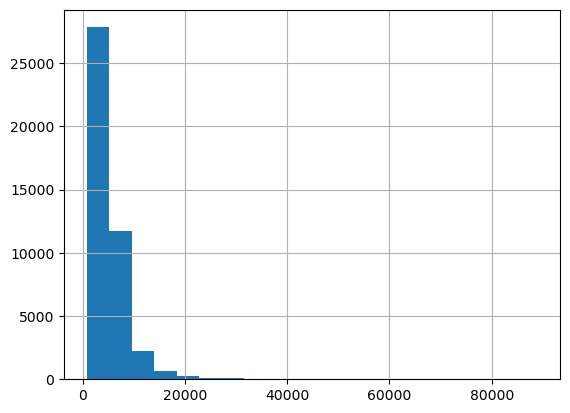

In [40]:
df_per_patent.description.map(len).hist(bins = 20)

In [41]:
data = df_per_patent
data

,patent_id,recid,occhisco,description,street,city,county,state,region,full_address
0,US100001A,[1119227.0],[54010.0],J. ARRINGTON. Walking Planter. N. PETERS. PHOT...,[],[Livingston],[Sumter],[Alabama],[],"[Livingston, Sumter, Alabama]"
1,US100007A,[38084797.0],[83850.0],Ι/ί/ΐΒ/9^21 N.PETERS. PHOTO-UTHOGRAPHER. WASHI...,[],[Altoona],[Blair],[Pennsylvania],[],"[Altoona, Blair, Pennsylvania]"
2,US100024A,[40470809.0],[87340.0],"No. 100,024. G. PROS. STOVE GRATE. Patented Fe...",[],[Philadelphia],[],[Pennsylvania],[],"[Philadelphia, Pennsylvania]"
3,US100037A,[6771858.0],[83400.0],"No. 100,037. A. D. HOFFMAN. Till Alarm. Patent...",[],[Chicago],[Cook],[Illinois],[],"[Chicago, Cook, Illinois]"
4,US100041A,[14941022.0],[99999.0],"N.PETERS, PHOTO-LITHOGRAPHER, WASHINGTON. DC. ...",[],[Maysville],[Mason],[Kentucky],[East South Central Division],"[Maysville, Kentucky]"
...,...,...,...,...,...,...,...,...,...,...
42941,US99984A,[28434939.0],[39310.0],N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON D. C...,[],[Buffalo],[Erie],[New York],[],"[Buffalo, NY]"
42942,US99985A,[31600299.0],[75600.0],"WEGNER &amp;, SCHLEETER. Churn. Patented Feb. ...",[],[West Troy],[Albany],[New York],[],"[West Troy, Albany, New York]"
42943,US99987A,[29132340.0],[79920.0],ft. JY&amp;. 8808/. 437 Τίύ./5./8/0. N. PETERS...,[],[Brooklyn],[Kings],[New York],[],"[Brooklyn, Kings County, New York]"
42944,US99991A,[46549109.0],[81300.0],"F-F/ibml·, Ctimieiw. Mb. ffffffff/. EhhiU J/ /...",[],[Londonderry],[Windham],[Vermont],[],"[Londonderry, Windham, Vermont]"


In [42]:
import pandas as pd
import os
import re
import nltk
from nltk.stem import WordNetLemmatizer

# Download WordNet data from NLTK
nltk.download('wordnet')

############  1.0. Selection based on localised inventors  ############

############ 1.1 Data ############
# Load CSV files containing authors, titles, and occupations information
inventors = pd.read_csv("../int_data/Authors_US.csv")
inventors.rename(columns={'publicationnumber': 'i', 'name':'names'}, inplace=True)

inventors_wide = pd.read_csv('../int_data/Authors_wide_US.csv')
inventors_wide.rename(columns={'publicationnumber': 'i', 'name':'names'}, inplace=True)

# titles = pd.read_csv("../ori_data/Titles.csv")
# titles.rename(columns={'ID_patent': 'i'}, inplace=True)
# Only 189 rows got title in the description (or not in it?) -> We don't need to filter Title out from description

# Load occupation data
occupations = pd.read_csv("../ori_data/Occupation_string3.csv")

############ 1.2 Clean occupation titles ############
# Initialize lemmatizer for singularizing terms
lemmatizer = WordNetLemmatizer()

def clean_term(term):
    # Remove specific characters, numbers, and extra spaces from occupation terms
    term = re.sub(r"- ", "", term)                    # Remove hyphens
    term = re.sub(r"[[:punct:]]", " ", term)           # Remove punctuation
    term = re.sub(r"([0-9]+)", "", term)              # Remove numbers
    term = term.upper()                                  # Convert to uppercase
    term = lemmatizer.lemmatize(term)                    # Convert to singular form
    term = re.sub(r"BRIDGE", "", term)                # Remove specific word "BRIDGE"
    term = re.sub(r"ETC", "", term)                   # Remove specific word "ETC"
    term = re.sub(r"\s+", " ", term).strip()         # Remove extra spaces and trim
    return term

# Apply cleaning function to occupation terms
occupations['term'] = occupations['term'].apply(clean_term)

# Create a copy of occupations and convert terms to plural form
def pluralize_term(term):
    # Here, we simply add an 'S' to pluralize; consider using a more sophisticated pluralizer if needed
    return term + 'S'

occupations2 = occupations.copy()
occupations2['term'] = occupations2['term'].apply(pluralize_term)

# Combine original and pluralized occupation terms into a single dataframe
occupations = pd.concat([occupations, occupations2], ignore_index=True)

# Remove duplicate occupation terms
occupations.drop_duplicates(subset='term', inplace=True)

# Remove any rows with empty occupation terms
occupations = occupations[occupations['term'] != '']

############ 1.3 Clean inventor names ############
# Fill missing values in inventor names
inventors['names'] = inventors['names'].fillna('')
inventors_wide['names'] = inventors_wide['names'].fillna('')

# Function to clean inventor names
def clean_names(name):
    name = re.sub(r"- ", "", name)                    # Remove hyphens
    name = re.sub(r"[^[:punct:],]", " ", name)        # Remove non-punctuation characters
    name = re.sub(r"([0-9]+)", "", name)              # Remove numbers
    name = name.upper()                                  # Convert to uppercase
    name = re.sub(r"\s+", " ", name).strip()         # Remove extra spaces and trim
    return name

# Apply cleaning function to inventor names
inventors['names'] = inventors['names'].apply(clean_names)
inventors_wide['names'] = inventors_wide['names'].apply(clean_names)

############ 1.4 Clean patent titles ############
# Fill missing values in patent titles
# titles['title'] = titles['title'].fillna('')

# # Function to clean patent titles
# def clean_titles(title):
#     title = re.sub(r"<RTI> & </RTI>", "", title)      # Remove specific tags
#     title = re.sub(r"</?RTI>", "", title)             # Remove RTI tags
#     title = re.sub(r"~", "", title)                   # Remove tilde characters
#     title = re.sub(r"- ", "", title)                  # Remove hyphens
#     title = re.sub(r"[[:punct:]]", " ", title)        # Remove punctuation
#     title = title.upper()                                # Convert to uppercase
#     title = re.sub(r"\s+", " ", title).strip()       # Remove extra spaces and trim
#     return title

# # Apply cleaning function to patent titles
# titles['title'] = titles['title'].apply(clean_titles)

# Fill missing values in descriptions
data['description'] = data['description'].fillna('')
data['description'] = data['description'].apply(lambda x: re.sub(r"([0-9]+)", "", x))  # Remove numbers from description

############ 1.5 Merge ############
# Rename "Patent_ID" column to "i"
data = data.rename(columns={'patent_id': 'i'})

# Merge data with inventors_wide and titles datasets
data = pd.merge(data, inventors_wide, on='i')
# data = pd.merge(data, titles, on='i')

# Remove rows with 'NA' in the description
data = data[data['description'] != 'NA']

# Word count
word_count = data['description'].str.split().str.len().sum()
word_count_df = pd.DataFrame({'w1': [word_count]})

print("Word Count (W1):", word_count)

# ############ 2 Merge Inventors: from 156,913 to 113,512 ############
# found_inventors = pd.read_csv(os.path.join(out_path, "Localised_inventors_v3.csv"))
# found_inventors.rename(columns={found_inventors.columns[0]: 'i'}, inplace=True)

# # Merge data with found inventors
# data = pd.merge(data, found_inventors, on='i')

# # Word count after merging inventors
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w2'] = word_count

# print("Word Count (W2):", word_count)

############ 3. First cleaning ############
# Function to clean descriptions
def clean_description(description):
    description = re.sub(r"<RTI> & </RTI>", "", description)      # Remove specific tags
    description = re.sub(r"</?RTI>", "", description)             # Remove RTI tags
    description = re.sub(r"~", "", description)                   # Remove tilde characters
    description = re.sub(r"- ", "", description)                  # Remove hyphens
    description = re.sub(r"[[:punct:]]", " ", description)        # Remove punctuation
    description = description.upper()                                # Convert to uppercase
    description = re.sub(r"\s+", " ", description).strip()       # Remove extra spaces and trim
    description = re.sub(r" IMG | CLASS | EMIREF | ID | CLSS ", " ", description)  # Remove specific words
    description = re.sub(r"\d{4,}", "", description)             # Remove years and large numbers
    description = re.sub(r"PROVISIONAL | PROVISIONL | PROVIIONAL | PRVISINAL | COMPLETE", " ", description)
    description = re.sub(r" SPECIFICATION | SPECIFCATION | PECIFICATION | SPECIFICTION | SPECIFICATIN ", " ", description)
    description = re.sub(r" IMPROVEMENTS | IMPROVED | THE NATURE OF THIS INVENTION | TO BE AS FOLLOWS | RTI ", " ", description)
    description = re.sub(r"000", "", description)                  # Remove '000'
    description = re.sub(r"\d+", "", description)                # Remove all remaining numbers
    return description

# Apply cleaning function to descriptions
data['description'] = data['description'].apply(clean_description)

# Remove rows with empty descriptions
data = data[data['description'] != '']

# Word count after first cleaning
word_count = data['description'].str.split().str.len().sum()
word_count_df['w3'] = word_count

print("Word Count (W3):", word_count)


[nltk_data] Downloading package wordnet to /users/xiet13/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Word Count (W1): 39280935
Word Count (W3): 39148766


In [43]:
data.to_pickle("../int_data/US_all_patent_cleaned_section_3.pkl")
data = pd.read_pickle("../int_data/US_all_patent_cleaned_section_3.pkl")

In [44]:
# !mv ../int_data/all_patent_cleaned_section_3.pkl ../int_data/deprecated_all_patent_cleaned_section_3.pkl

<Axes: >

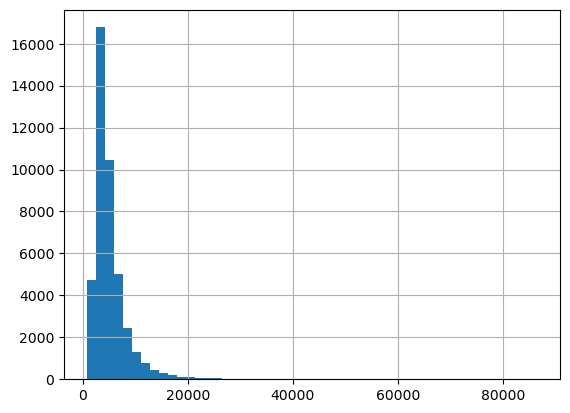

In [45]:
data.description.str.strip().map(len).hist(bins = 50)

In [46]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

# Download necessary NLTK data
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

############ Step 4: Remove Intro, Location Names, Stopwords ############

# Assuming `data` DataFrame is already defined

# Remove intro text
data['pos2'] = data['description'].str.find('DO HEREBY DECLARE')
data['max'] = data['description'].str.len()
data['pos2'] = np.where(data['pos2'] == data['max'], 1, data['pos2'])
data['pos2'] = np.where(data['pos2'] > 500, 1, data['pos2'])
data['description'] = data.apply(lambda row: row['description'][row['pos2']:] if row['pos2'] > 0 else row['description'], axis=1)
data['description'] = data['description'].str.replace('DO HEREBY DECLARE', ' ', regex=False)

# Remove town names
town_columns = ['street', 'city', 'county', 'state', 'region', 'full_address']
town = pd.concat([data[col].dropna().rename('location') for col in town_columns], ignore_index=True).explode()
towns_unique = town.unique()
towns_set = set(town.lower() for town in towns_unique if pd.notna(town))  # Use lowercase for consistency

# Remove stopwords
stop_words = set(stopwords.words('english'))

# Combine all words to remove into a single set for efficient filtering
unwanted_words = towns_set.union(stop_words)

# Define a function to remove unwanted words using naive filtering
def remove_unwanted_words_naive(description, unwanted_set):
    words = description.split()
    cleaned_words = [word for word in words if word.lower() not in unwanted_set]
    return ' '.join(cleaned_words)

# Apply removal of unwanted words with pandas `map` function
tqdm.pandas(desc="Removing unwanted words")
data['description'] = data['description'].progress_map(lambda desc: remove_unwanted_words_naive(desc, unwanted_words))

############ Step 5: Remove Duplicate Words Within Each Description ############

def remove_duplicates(description):
    return ' '.join(pd.unique(description.split()))

# Apply duplicate removal using `map` function
data['description'] = data['description'].map(remove_duplicates)

############ Step 6: Word Count After Removing Stopwords ############

# Calculate the total word count after all the removals
word_count = data['description'].str.split().str.len().sum()
word_count_df = pd.DataFrame()  # Assuming word_count_df needs to be defined
word_count_df['w4'] = [word_count]

print("Word Count (W4):", word_count)

############ Diagnosing Potential "No Spaces Between Words" Issue ############

# Explanation for no spaces between words:
# - When removing specific patterns or text, there is the risk of removing spaces alongside the target text.
# - We replaced each match with a space (' ') to ensure that even after the removal, words are still separated.
# - After all replacements, `.str.replace(r'\s+', ' ', regex=True).str.strip()` ensures proper spacing and removes any extra spaces.

# Final adjustments to remove extra spaces between words
data['description'] = data['description'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Save the cleaned data if necessary
data.to_pickle("../int_data/US_all_patent_cleaned_section_4.pkl")


[nltk_data] Downloading package stopwords to
[nltk_data]     /users/xiet13/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Removing unwanted words: 100%|██████████| 42946/42946 [00:04<00:00, 9944.61it/s] 
/tmp/ipykernel_8875/1101300367.py:49: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return ' '.join(pd.unique(description.split()))


Word Count (W4): 12298701


<Axes: >

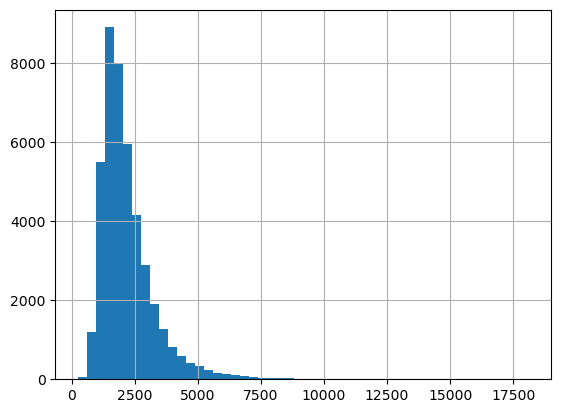

In [47]:
data.description.str.strip().map(len).hist(bins = 50)

In [48]:
import pandas as pd
data = pd.read_pickle("../int_data/US_all_patent_cleaned_section_4.pkl")

In [52]:
data

,i,recid,occhisco,description,street,city,county,state,region,full_address,names,pos2,max
0,US100001A,[1119227.0],[54010.0],"FOLLOWING FULL, CLEAR, EXACT DESCRIPTION THERE...",[],[Livingston],[Sumter],[Alabama],[],"[Livingston, Sumter, Alabama]","JOSEPH ARRINGTON, N. PETERS",496,6202
1,US100007A,[38084797.0],[83850.0],/Ί/Ϊ́Β/^ N.PETERS. PHOTO-UTHOGRAPHER. WASHING...,[],[Altoona],[Blair],[Pennsylvania],[],"[Altoona, Blair, Pennsylvania]","N. PETERS, WILLIAM A. BOYDEN, CHARLES J. MANN",1,2746
2,US100024A,[40470809.0],[87340.0],"NO. ,. G. PROS. STOVE GRATE. PATENTED FEB. , ....",[],[Philadelphia],[],[Pennsylvania],[],"[Philadelphia, Pennsylvania]",GEORGE FROH,-1,3885
3,US100037A,[6771858.0],[83400.0],"O. ,. A. D. HOFFMAN. TILL ALARM. PATENTED FEB....",[],[Chicago],[Cook],[Illinois],[],"[Chicago, Cook, Illinois]",AUSTIN D. HOFFMAN,1,3889
4,US100041A,[14941022.0],[99999.0],"FOLLOWING FULL, CLEAR, EXAET DESCRIPTION THERE...",[],[Maysville],[Mason],[Kentucky],[East South Central Division],"[Maysville, Kentucky]","N. PETERS, JAMES JACOBS",445,3221
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42941,US99984A,[28434939.0],[39310.0],N. PETERS. PHOTO-LITHOGRAPHER. D. C. UNITED J-...,[],[Buffalo],[Erie],[New York],[],"[Buffalo, NY]","N. PETERS, JOHN V. WACKERMAN",-1,3374
42942,US99985A,[31600299.0],[75600.0],"EGNER &AMP;, SCHLEETER. CHURN. PATENTED FEB. ,...",[],[West Troy],[Albany],[New York],[],"[West Troy, Albany, New York]","FRIEDRICH WEGNER, CHARLES SCHLEETER",1,5832
42943,US99987A,[29132340.0],[79920.0],"FOLLOWING FULL, CLEAR, EXACT DESCRIPTION THERE...",[],[Brooklyn],[Kings],[New York],[],"[Brooklyn, Kings County, New York]","ROBERT WENT, N. PETERS",484,3011
42944,US99991A,[46549109.0],[81300.0],"FOLLOWING FULL, CLEAR, EXACT DESCRIPTION THERE...",[],[Londonderry],[Windham],[Vermont],[],"[Londonderry, Windham, Vermont]",SILAS WHITMAN,500,1808


In [54]:
data.occhisco.map(len).value_counts(dropna=True)

occhisco
1    41959
2      962
3       25
Name: count, dtype: int64

In [55]:
# Section 5-13: lemmateise and then remove
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
from scipy.sparse import csr_matrix

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('stopwords')

############ Step 5: Remove Low-Frequency Terms ############

# Create term frequency data
vectorizer = CountVectorizer()
x_counts = vectorizer.fit_transform(data['description'])

# Convert to sparse format to save memory
x_counts_sparse = csr_matrix(x_counts)

# Sum term frequencies in sparse format
term_freq = x_counts_sparse.sum(axis=0)

# Convert term frequencies to a DataFrame
term_freq_df = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'freq': term_freq.A1
})
terms_to_remove = term_freq_df[term_freq_df['freq'] <= 2]['term'].tolist()

############ Step 6: Define Non-Technical Words (1) ############

non_technical_words_1 = [
    "RTI", "INVENTION", "END", "FIG", "FIGURE", "MEANS", "OPEN", "PROCESS", "PERMANENT",
    "TAKE", "MAKE", "THREAD", "STATE", "PROCEED", "THEREOF", "ORDINARY", "USUAL",
    # ... (add more words here)
]

############ Step 7: Load and Clean Inventor Names ############

# Assuming 'input_path' is defined and points to the directory containing "Authors.csv"
input_path = "./"  # Update this to the correct path

# Load inventors file
inventors = pd.read_csv("../int_data/Authors_US.csv")
inventors.rename(columns={'publicationnumber': 'i'}, inplace=True)

# Join with data
inventors = pd.merge(inventors, data, on='i')

# Clean inventor names
def clean_inventor_names(name):
    name = re.sub(r"- ", "", name)
    name = re.sub(r"[[:punct:]]", " ", name)
    name = name.upper()
    name = re.sub(r"\s+", " ", name).strip()
    return name

inventors['names'] = inventors['names'].fillna('').apply(clean_inventor_names)
inventors_unique = inventors['names'].unique().tolist()

############ Step 8: Define Additional Non-Technical Words ############

additional_non_technical_words = [
    "PERFORM", "ASCERTAIN", "ACCOMPANY", "RELATE", "OBJECT", "CARRY", "PASS",
    "CONSIST", "COUNTY", "EFFECT", "REFERENCE", "UPPER", "REQUIRE", "PLAN",
    # ... (add more words here)
]

############ Step 9: Combine All Words to be Removed ############

all_words_to_remove = set(terms_to_remove + non_technical_words_1 + additional_non_technical_words + inventors_unique)

############ Step 10: Lemmatize the Text ############

lemmatizer = WordNetLemmatizer()

def lemmatize_text(description):
    return ' '.join([lemmatizer.lemmatize(word) for word in description.split()])

# Apply lemmatization in parallel
tqdm.pandas(desc="Lemmatizing text")
data['description'] = Parallel(n_jobs=-1)(
    delayed(lemmatize_text)(desc) for desc in tqdm(data['description'], desc="Lemmatizing text")
)

############ Step 11: Remove All Unwanted Words in One Pass ############

def remove_unwanted_words(description, words_to_remove = all_words_to_remove):
    return ' '.join([word for word in description.split() if word not in words_to_remove])

# Apply removal in parallel
# tqdm.pandas(desc="Removing all undesired words")
# data['description'] = Parallel(n_jobs=-1)(
#     delayed(remove_unwanted_words)(desc, all_words_to_remove) for desc in tqdm(data['description'], desc="Removing all undesired words")
# )

tqdm.pandas(desc="Removing all undesired words")
data['description'] = data['description'].map(remove_unwanted_words)

############ Step 12: Optional - Remove Duplicates Within Each Cell ############

def remove_duplicates(description):
    return ' '.join(pd.unique(description.split()))

# Apply duplicate removal
data['description'] = data['description'].map(remove_duplicates)

## Extra
############ KEEP ONLY WORDS FOUND IN THE DICTIONARY ############
from nltk.corpus import words
import nltk
nltk.download('words')

dictionary = set([w.upper() for w in words.words()])

def keep_words_in_dict(s):
    return ' '.join([word for word in s.split() if word in dictionary])

data['description'] = data['description'].map(keep_words_in_dict)
data

############ Step 13: Save Final Data ############

# Assuming 'out_path' is defined for the output file path
out_path = "./"  # Update this to your desired output path
output_file = os.path.join(out_path, "../int_data/Input_patent_matrix_US.csv")
data.to_csv(output_file, index=False)
print(f"Data saved to {output_file}")

[nltk_data] Downloading package wordnet to /users/xiet13/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/xiet13/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Lemmatizing text: 100%|██████████| 42946/42946 [00:05<00:00, 7333.19it/s] 
/tmp/ipykernel_8875/3734508541.py:110: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return ' '.join(pd.unique(description.split()))
[nltk_data] Downloading package words to /users/xiet13/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data saved to ./../int_data/Input_patent_matrix_US.csv


In [36]:
# !mv ../int_data/Input_patent_matrix_US.csv ../int_data/deprecated_Input_patent_matrix_US.csv

In [56]:
data = pd.read_csv("../int_data/Input_patent_matrix_US.csv")
data

,i,recid,occhisco,description,street,city,county,state,region,full_address,names,pos2,max
0,US100001A,[1119227.0],[54010.0],FOLLOWING EXACT DESCRIPTION ENABLE SKILLED ART...,[],['Livingston'],['Sumter'],['Alabama'],[],"['Livingston, Sumter, Alabama']","JOSEPH ARRINGTON, N. PETERS",496,6202
1,US100007A,[38084797.0],[83850.0],UNITED WILLIAM PATENT IMPROVEMENT SCHEDULE MAK...,[],['Altoona'],['Blair'],['Pennsylvania'],[],"['Altoona, Blair, Pennsylvania']","N. PETERS, WILLIAM A. BOYDEN, CHARLES J. MANN",1,2746
2,US100024A,[40470809.0],[87340.0],STOVE UNITED PATENT GEORGE FEBRUARY SCHEDULE M...,[],['Philadelphia'],[],['Pennsylvania'],[],"['Philadelphia, Pennsylvania']",GEORGE FROH,-1,3885
3,US100037A,[6771858.0],[83400.0],TILL UNITED J STENT ASSIGNOR PATENT ELATED FEB...,[],['Chicago'],['Cook'],['Illinois'],[],"['Chicago, Cook, Illinois']",AUSTIN D. HOFFMAN,1,3889
4,US100041A,[14941022.0],[99999.0],FOLLOWING DESCRIPTION ENABLE SKILLED ART USE D...,[],['Maysville'],['Mason'],['Kentucky'],['East South Central Division'],"['Maysville, Kentucky']","N. PETERS, JAMES JACOBS",445,3221
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42941,US99984A,[28434939.0],[39310.0],UNITED PATENT JOHN NEW FEBRUARY SCHEDULE MAKIN...,[],['Buffalo'],['Erie'],['New York'],[],"['Buffalo, NY']","N. PETERS, JOHN V. WACKERMAN",-1,3374
42942,US99985A,[31600299.0],[75600.0],WEST NEW PATENT FEBRUARY IMPROVEMENT SCHEDULE ...,[],['West Troy'],['Albany'],['New York'],[],"['West Troy, Albany, New York']","FRIEDRICH WEGNER, CHARLES SCHLEETER",1,5832
42943,US99987A,[29132340.0],[79920.0],FOLLOWING EXACT DESCRIPTION ENABLE SKILLED ART...,[],['Brooklyn'],['Kings'],['New York'],[],"['Brooklyn, Kings County, New York']","ROBERT WENT, N. PETERS",484,3011
42944,US99991A,[46549109.0],[81300.0],FOLLOWING EXACT DESCRIPTION MARKED PART NATURE...,[],['Londonderry'],['Windham'],['Vermont'],[],"['Londonderry, Windham, Vermont']",SILAS WHITMAN,500,1808


In [57]:
# Optional: Recalculate term frequencies after cleaning, if needed
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

# Create term frequency data again after cleaning
vectorizer = CountVectorizer()
x_counts = vectorizer.fit_transform(data['description'])
x_counts_sparse = csr_matrix(x_counts)

# Sum term frequencies in sparse format
term_freq = x_counts_sparse.sum(axis=0)

# Convert term frequencies to a DataFrame
term_freq_df = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'freq': term_freq.A1
})

# Display the cleaned term frequencies to verify
print(term_freq_df.head(20))

            term  freq
0             aa    27
1            aal     1
2            aam     1
3          aaron   101
4             ab   167
5            aba     3
6          aback    12
7          abaft     4
8        abandon    27
9      abandoned     6
10   abandonment     4
11          abas     5
12         abase     4
13         abate     2
14     abatement     1
15           abb    14
16          abba     2
17         abbey     1
18    abbreviate     1
19  abbreviation     1


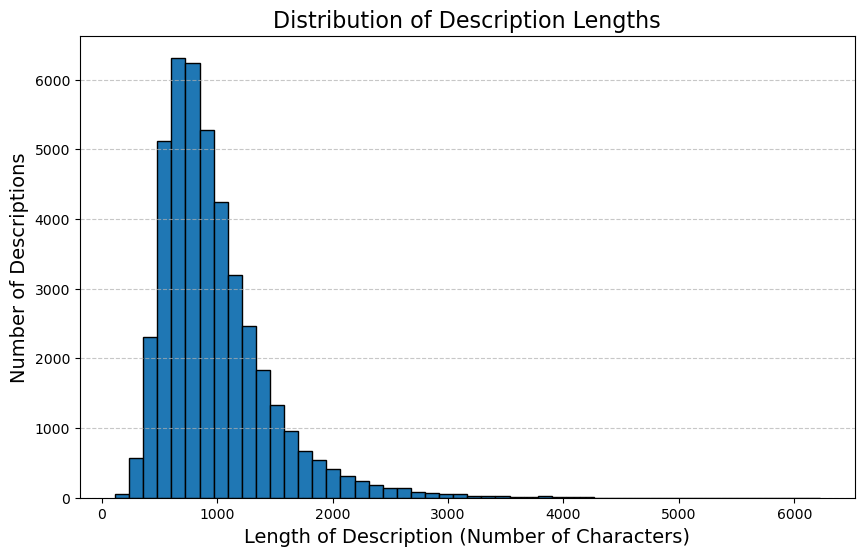

In [58]:
import matplotlib.pyplot as plt

# Step 1: Clean up the whitespace in each description and calculate the length
description_lengths = data['description'].str.strip().map(len)

# Step 2: Plot a histogram of the lengths of descriptions
plt.figure(figsize=(10, 6))
plt.hist(description_lengths, bins=50, edgecolor='black')

# Step 3: Labeling the axes and adding a title for clarity
plt.xlabel('Length of Description (Number of Characters)', fontsize=14)
plt.ylabel('Number of Descriptions', fontsize=14)
plt.title('Distribution of Description Lengths', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [ ]:
data[data.description.map(len) < 2000].shape

In [ ]:
data['description'][0]

In [ ]:
data

In [ ]:
input_path

In [ ]:
# import pandas as pd
# import os
# import re
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer

# # Download necessary NLTK data
# nltk.download('wordnet')
# nltk.download('stopwords')

# ############ 5. REMOVE TERMS THAT APPEAR ONCE OR TWICE ############
# # Create term frequency data
# vectorizer = CountVectorizer()
# x_counts = vectorizer.fit_transform(data['description'])
# # term_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'freq': x_counts.toarray().sum(axis=0)})

# # # Remove terms that appear once or twice
# from scipy.sparse import csr_matrix
# import pandas as pd

# # Convert to sparse format to save memory
# x_counts_sparse = csr_matrix(x_counts)

# # Sum term frequencies in sparse format
# term_freq = x_counts_sparse.sum(axis=0)

# # Convert term frequencies to a DataFrame
# term_freq_df = pd.DataFrame({
#     'term': vectorizer.get_feature_names_out(),
#     'freq': term_freq.A1  # Converts sparse matrix to array for a single row
# })

# print(term_freq_df)
# terms_to_remove = term_freq_df[term_freq_df['freq'] <= 2]['term'].tolist()

# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in terms_to_remove]))

# # Word count after removing low-frequency terms
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w5'] = word_count
# print("Word Count (W5):", word_count)

# ############ 6. REMOVE N MOST FREQUENT NON-TECHNICAL WORDS (1) ############
# # Remove specified non-technical words
# non_technical_words_1 = [
#     "RTI", "INVENTION", "END", "FIG", "FIGURE", "MEANS", "OPEN", "PROCESS", "PERMANENT", "TAKE", "MAKE", "THREAD", "STATE", "PROCEED", "THEREOF", "ORDINARY", "USUAL", "CREATE", "DO", "MODE", "TREAT", "ELIMINATE", "FREE", "PRODUCE", "PREFER", "BOX", "FEET", "TH", "INTRODUCE", "POSITION", "CLASS", "SIDE", "IMG", "EMIREF", "PROVIDED", "MANNER", "SHOWN", "PART", "SUITABLE", "FORM", "CONNECTED", "FORMED", "NATURE", "SECTION", "ENDS", "SPECIFICATION", "LOWER", "DECLARE", "IMPROVEMENTS", "IMPROVED", "IMPROVE", "ARRANGED", "VIEW", "FIXED", "PORTION", "CONTACT", "SECURED", "LINE", "MOVEMENT", "DESIRED", "FRONT", "BACK", "BOTTOM", "DEVICE", "COMPLETE", "CONSTRUCTION", "DRAWING", "ORDER", "VERTICAL", "HORIZONTAL", "MOUNTED", "ARRANGEMENT", "ATTACHED", "TIME", "DIRECTION", "PURPOSE", "ACTION", "PLACE", "SIMILAR", "FIGS", "STATEMENT"
# ]

# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in non_technical_words_1]))

# # Word count after removing non-technical words
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w6'] = word_count
# print("Word Count (W6):", word_count)

# ############ 7. REMOVE INVENTOR NAMES ############ # No need, plus we don't have author csv for US
# inventors = pd.read_csv(os.path.join('../ori_data', "Authors.csv"))
# inventors.rename(columns={'ID_patent': 'i'}, inplace=True)
# inventors = pd.merge(inventors, data, on='i')

# # Clean inventor names
# def clean_inventor_names(name):
#     name = re.sub(r"- ", "", name)
#     name = re.sub(r"[[:punct:]]", " ", name)
#     name = name.upper()
#     name = re.sub(r"\s+", " ", name).strip()
#     return name

# inventors['names'] = inventors['names'].fillna('').apply(clean_inventor_names)
# inventors_unique = inventors['names'].unique().tolist()

# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in inventors_unique]))

# # Word count after removing inventor names
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w7'] = word_count
# print("Word Count (W7):", word_count)

############ 8. LEMMATIZE THE TEXT ############
lemmatizer = WordNetLemmatizer()
data['description'] = data['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
data['description'] = data['description'].str.upper()

# Remove non-technical words from the list V1 after lemmatizing
V1 = [lemmatizer.lemmatize(word) for word in non_technical_words_1]
V1 = [word.upper() for word in V1]
data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in V1]))

# Remove duplicates within each cell
data['description'] = data['description'].apply(lambda x: ' '.join(pd.unique(x.split())))

# Word count after lemmatizing
word_count = data['description'].str.split().str.len().sum()
word_count_df['w8'] = word_count
print("Word Count (W8):", word_count)

############ 9. REMOVE WORDS WITH LESS THAN 3 LETTERS ############
data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 3]))

# Word count after removing short words
word_count = data['description'].str.split().str.len().sum()
word_count_df['w9'] = word_count
print("Word Count (W9):", word_count)

############ 10. REMOVE N MOST FREQUENT NON-TECHNICAL WORDS (2) ############
# Remove additional specified non-technical words
additional_non_technical_words = [
    "PERFORM", "ASCERTAIN", "ACCOMPANY", "RELATE", "OBJECT", "CARRY", "PASS", "CONSIST", "COUNTY", "EFFECT", "REFERENCE", "UPPER", "REQUIRE", "PLAN", "WORK", "ILLUSTRATE", "TOP", "SMALL", "PIECE", "REFER", "PRESENT", "APPLY", "CONNECTION", "OPOSITE", "ACT", "PROJECT", "LARGE", "HAND", "READILY", "CAUSE", "SEPARATE", "PREVENT", "ENGINEER", "LEAVE", "DISTANCE", "OBTAIN", "CENTRE", "THERETO", "SERVE", "LONGITUDINAL", "INCREASE", "REDUCE", "PARTLY", "COUJTY", "ALLOW", "SIMPLE", "REAIN", "CITY", "STREET", "AFORESAID", "HALF", "DIRECTLY", "DESCRIPTION", "MODIFY", "ADVANTAGE", "TRAVEL", "SUFFICIENTLY", "HERETOFORE", "EFFICIENT", "ENSURE", "REGULAR", "OVERCOME", "IMMEDIATELY", "PND", "DIRECTOR", "UNDERNEATH", "INTEND", "DRAWING", "PREFERABLY", "EMPLOY", "FIT", "SHAPE", "TURN", "CONSTRUCT", "MATERIAL", "SUPPORT", "UNDERSTAND", "MOVE", "SURFACE", "ADAPT", "REMOVE", "EXTEND", "SET", "LEVAVE", "OPPOSITE", "OPERATE", "OUTER", "RECEIVE", "CLOSE", "ENGAGE", "POINT", "OPERATION", "LENGTH", "CASE", "COVER", "PIN", "REPRESENT", "LETTER", "ENABLE", "SPACE", "REST", "BRING", "CONVENIENT", "HEREINAFET", "DRIVE", "RAISE", "DETAIL", "METHOD", "HOLD", "SUFFICIENT", "SIZE", "ENTER", "VARY", "CLAIM", "AIR", "FIND", "RUN", "DESCRIBE", "PERMIT", "ADJUST", "GREAT", "HOLE", "INSERT", "PROPER", "GIVE", "HANDLE", "MECHANISM", "HIGH", "RESULT", "COMMUNICATE", "INSTANCE", "FULLY", "LIE", "SLIGHTLY", "INSIDE"
]

data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in additional_non_technical_words]))

# Strip whitespace and trim descriptions
data['description'] = data['description'].str.strip()

# Stem the descriptions using WordNet lemmatizer for a simpler transformation
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
data['description'] = data['description'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Remove duplicates within each cell again after stemming
data['description'] = data['description'].apply(lambda x: ' '.join(pd.unique(x.split())))

# Word count after removing most frequent words and stemming
word_count = data['description'].str.split().str.len().sum()
word_count_df['w10'] = word_count
print("Word Count (W10):", word_count)

# ############ 11. KEEP ONLY WORDS FOUND IN THE DICTIONARY ############ # didn't find 'words_alpha.txt'
# dictionary = pd.read_csv(os.path.join(input_path, "words_alpha.txt"), header=None, names=['word'])
# dictionary['word'] = dictionary['word'].str.upper()

# data['description'] = data['description'].apply(lambda x: ' '.join([word for word in x.split() if word in dictionary['word'].values]))

# # Word count after dictionary filtering
# word_count = data['description'].str.split().str.len().sum()
# word_count_df['w11'] = word_count
# print("Word Count (W11):", word_count)

############ 12. CONVERT DATAFRAME TO CORPUS ############
# Write final data to CSV
output_file = os.path.join(out_path, "Input_patent_matrix_US.csv")
data.to_csv(output_file, index=False)
print(f"Data saved to {output_file}")


In [70]:
# term_freq_df[term_freq_df.term.map(len)>12].sort_values('freq', ascending = True)[:60]
term_freq_df.sort_values('freq', ascending = False)[:60]

,term,freq
9550,may,27682
6164,following,27451
10981,part,23713
10553,one,23047
14062,side,21627
8670,known,21615
17502,view,20172
737,application,20005
10194,new,19758
17250,upon,19162


## Calculating

In [59]:
# Count the number of words in the 'description' column
df_per_patent['strcount'] = df_per_patent['description'].str.split().str.len()
# Filter the data based on the word count
# Too long or too short patents are filtered
df_per_patent = df_per_patent[(df_per_patent['strcount'] > 10) & (df_per_patent['strcount'] <= 500)].reset_index(drop = True)
df_per_patent

,patent_id,recid,occhisco,description,street,city,county,state,region,full_address,strcount
0,US100007A,[38084797.0],[83850.0],Ι/ί/ΐΒ/^ N.PETERS. PHOTO-UTHOGRAPHER. WASHINGT...,[],[Altoona],[Blair],[Pennsylvania],[],"[Altoona, Blair, Pennsylvania]",495
1,US100057A,[5187979.0],[61110.0],"Wniteil JHates Jatent (Bffhx J. T. MULKEY, OF ...",[],[Walton’s Ford],[Habersham],[Georgia],[],"[Walton’s Ford, Habersham, Georgia]",299
2,US100068A,[2934229.0],[80320.0],"k b J. E. REQU A. Carriage Spring. iVo. ,. Pat...",[],[Sonora],[Tuolumne],[California],[],"[Sonora, Tuolumne County, California]",297
3,US100098A,[2286669.0],[61110.0],"H. ALTER Wheelbarrow, N.PETERS, PHOTO-LITHOGRA...",[],[Lakeport],[Lake],[California],[],"[Lakeport, Lake, California]",435
4,US100108A,[8847194.0],[41010.0],"N.PETERS, PHOTO-LITHOGRAPHER. WASHINGTON. C. ...",[],[Washington],[Tazewell],[Illinois],[],"[Washington, Tazewell, Illinois]",448
...,...,...,...,...,...,...,...,...,...,...,...
7794,US99934A,[38436457.0],[95140.0],"WniteJ States Jatent CHRISTIAN MUIR, OF LOOKHA...",[],[Lockhaven],[Clinton],[Pennsylvania],[],"[Lockhaven, Clinton, Pennsylvania]",426
7795,US99960A,[31984003.0],[99999.0],"N.PCTERS, PHOTO-LITHOGRAPHER, WASHINGTON.' C. ...",[],[Odessa],[Schuyler],[New York],[Middle Atlantic Division],"[Odessa, Schuyler County, New York]",368
7796,US99967A,[28371849.0],[83400.0],Ά&amp;ΖDi. /. /ύ/Α Ν. PETERS. PHOTO-UTHOGRAPHE...,[],[Hamburg],[Erie],[New York],[],"[Hamburg, NY]",347
7797,US99980A,[2837288.0],[92110.0],M meel. Λ&amp;. gy&amp;gff Άν/ΛΙΆ /.//. N. PET...,[],[Downieville],[Sierra],[California],[],"[Downieville, Sierra, California]",490


In [62]:
df_per_patent.occhisco.map(len).value_counts(dropna=False)

occhisco
1    7637
2     158
3       4
Name: count, dtype: int64